In this problem set we are going to make use of `pandas` to analyze the effect of a fictuous experiment I have added to a data set. The data will be using is the sample data provided by Yelp. The goal is to familiarize ourselves with working with such datasets.

[Download notebook :fontawesome-solid-download:](../pi.ipynb){: .md-button .md-button--primary download="hw-quasi.ipynb"}

The original data is available here: [Yelp data](https://www.yelp.com/dataset/download).
However for this homework you will have to use the data I constructed from the original sample. You can download such file here: 

 - **homework data**: [hw-yelp.tar.gz](http://econ21340.lamadon.com/hw-yelp.tar.gz) (~2.6Go)

Note that on windows you can use [7zip](https://www.7-zip.org/download.html) to uncompress that file. On OSX and linux you can simply use `tar -cxvf hw-yelp.tar.gz`

In the data I have introduced an experiment. The back sotry is that Yelp rolled out a new interface for a randomly select group of users. These uses were randomly selected among users that posted a review in the month of January 2010. The `id` of these users in listed in the `yelp_academic_dataset_review_treatment.json` file present in the archive.

For this group of user a the new website interface was put in place on February 1st 2010. As a Yelp employee you are asked to analyze the impact of a new app. The company is interested in the effect on user engagement which is measured by rating activity. We will focus on the number of ratings.

In this homework we will cover:
 1. loading large data using streaming/chunks, learn about json
 - working with date in pandas
 - analyze randomly assigned treatment
 - construct comparable control group
 - analyze at the level of randomization
 
some useufl links:
 - [tutorial on dates in pandas](https://pbpython.com/pandas-grouper-agg.html)
 - [pandas documentation on reshaping](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)
 - [yelp data documentation](https://www.yelp.com/dataset/documentation/main)

We start with a simple list of imports, as well as defining the path to the file we will be using. Please update the paths to point to the correct location on your computer.

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_review = os.path.expanduser("C:/Users/diogo/Desktop/Classes/ECMA 21340/Pset HWSI/yelp_academic_dataset_review_experiment.json")
file_treatment = os.path.expanduser("C:/Users/diogo/Desktop/Classes/ECMA 21340/Pset HWSI/yelp_academic_dataset_review_treatment.json")

def file_len(fname):
    """ Function which efficiently computes the number of lines in file"""
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


You are already familiar with the following section, this is the code that loads my solution. Since you don't have the file, this part of the code won't work for you. 

In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\diogo\Desktop\Classes\ECMA 21340



# Loading the yelp review data

The data is stored in `json` format. This is a widely used format to store structured data. See [here](https://www.w3schools.com/python/python_json.asp) for working with json in general in python.

The data itself is quite large, hence we are going to use the `chunksize` argument of the `read_json` function of `pandas`. You can of course try for your self to directly load the data by using `pd.read_json(file_review)`, this however might take a while!

In the following section I provide a code example that loads the business information using chunks of size `100,000`. The code **contains a few errors**. Use the data documentation (using the link in the intro) to fix the code a load the data. The code also drops variables which will be very needed and keep some others that are just going to clutter your computer memory. Again, look at the documentation and at the questions ahead to keep the right set of variables.


Note how the code first compute the length of the file 

```python
size = 100000
review = pd.read_json(filepath, lines=True,
                      dtype={'review_id':str,
                             'user_id':float,
                             'business_id':str,
                             'stars':int,
                             'date':str,
                             'text':float,
                             'useful':int,
                             'funny':str,
                             'cool':int},
                      chunksize=size)

chunk_list = []
for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','date'], axis=1)
    chunk_list.append(chunk_review)

df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
```

The following runs my version of the code, it takes around 2 minutes on my laptop. I show you a few of the columns that I chose to extract. In particular, you can check that you get the right row count of `7998013`. 

In [3]:
def question1(file_path):
    size = 100000
    review = pd.read_json(file_path, lines=True,
                          dtype={'review_id':str,
                                 'user_id':str,
                                 'business_id':str,
                                 'stars':int,
                                 'date':str,
                                 'text':str,
                                 'useful':int,
                                 'funny':int,
                                 'cool':int},
                          chunksize=size)

    chunk_list = []
    for chunk_review in tqdm.tqdm(review, total=np.ceil( file_len(file_path)/size )  ):
        # Drop columns that aren't needed
        chunk_review = chunk_review.drop(['text', 'funny', 'cool', 'useful'], axis=1)
        chunk_list.append(chunk_review)

    df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
    
    return df

In [4]:
df_review = question1(file_review)
df_review['date'] = pd.to_datetime(df_review.date) # convert the date string to an actual date
#df_review[['review_id','user_id','date']]

100%|████████████████████████████████████████████████████████████████████████████████| 80/80.0 [02:03<00:00,  1.55s/it]


In [8]:
df_review[['review_id','user_id','date']]

,review_id,user_id,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57
...,...,...,...
7998008,LAzw2u1ucY722ryLEXHdgg,6DMFD3BRp-MVzDQelRx5UQ,2019-12-11 01:07:06
7998009,gMDU14Fa_DVIcPvsKtubJA,_g6P8H3-qfbz1FxbffS68g,2019-12-10 04:15:00
7998010,EcY_p50zPIQ2R6rf6-5CjA,Scmyz7MK4TbXXYcaLZxIxQ,2019-06-06 15:01:53
7998011,-z_MM0pAf9RtZbyPlphTlA,lBuAACBEThaQHQGMzAlKpg,2018-07-05 18:45:21


# Our first plot of the data

Next, to get a sense of the data, we plot the user engagement over time. For this I ask you to plot the log number of reviews per month using our created data. 

To get to the result I recommend you look into either the `resample` menthod or the `grouper` method. If you are not too familiar with them, I added a link at the top to a great tutorial.

In [5]:
def question2(df):
    q2 = df.groupby(pd.Grouper(key = 'date', freq="M"))['review_id'].size()
    q2.plot()
    plt.yscale("log")   
    
    plt.title('log number of reviews per month')
    plt.xlabel('date')
    plt.ylabel('log reviews')
    return  plt.show()

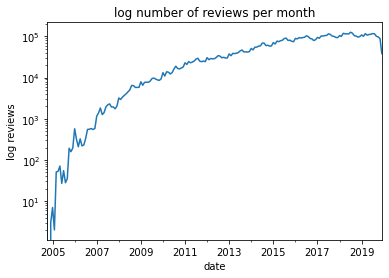

In [7]:
question2(df_review)

# A randomized experiment

We now want to extract our experimental data from our large data set. Given the random assignment we are going to compare the treated group to simply everyone else in the data. In this exercice, we are interested in the effect of the policy overt time. We are then going to look at the log number of reviews in each of the month around the introduction of the interface change.

I would like for you to do the following:
 1. extract the list of treated individuals from the provided file
 2. attach the treated status to each observation in the data, you can use `eval` or a merge.
 3. plot the log number of reviews per month in the treatment and in the control group. 
 4. given that the treatment status was randomized, the picture should look a bit surpising, please explain what you would have expected to see.
 
Here is the plot I get, try to reproduce it as closely as possible.

In [9]:
#Part 1: Extraction
def question3_1(file_path):
    treatment_id = pd.read_json(file_path, lines=True)
    treatment_id.rename( columns={0 :'users'}, inplace=True )
    return treatment_id['users'].tolist()

In [10]:
treatment = question3_1(file_treatment)

In [11]:
#Part 2: Attach Treated Status
df_review['treated'] = df_review['user_id'].isin(treatment)


In [12]:
#Part 3: Plot + Calculate log number of reviews
q3_control = df_review[df_review['treated']==False]
df_local = df_review[df_review['treated']==True]


q3_control = q3_control.groupby(pd.Grouper(key = 'date', freq="M"))['review_id'].size()
q3_treatment = df_local.groupby(pd.Grouper(key = 'date', freq="M"))['review_id'].size()

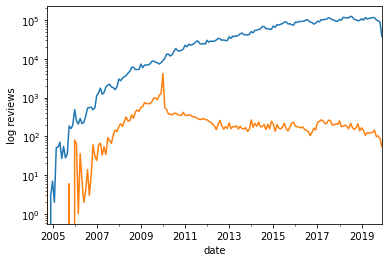

In [13]:
q3_control.plot()
plt.yscale("log")  
q3_treatment.plot()
plt.yscale("log")  

plt.xlabel('date')
plt.ylabel('log reviews')
plt.show()

These results are surprising because I would expect that those users that gave reviews before would be more inclined to write more reviews after their interface has changed - whether they liked or disliked it. It's even more surprising that this randomly selected group of people would all start reviewing less frequently than the control group after this shift.

# Changing comparaison group

We clearly created some issues in the way we analyzed our sample. In this section we are going to use a more comparable group. 

 1. using the criteria descriged in the intro, construct the original set of users from which the treatment group was selected. 
 - extracts the users from the this group wich are not in the treatment group, this will be our control group.
 - using this new control group, plot the log number of reviews in each **quarter** for treatment and control
 - finally plot the outcome in difference, however make sure to remove the log-number of individual from each group to plot the log number of reviews per user, overwise your intercept won't be around 0!
 
Here are the plots I got: 

In [14]:
# Original set of users for treatment group selection
jan_df = df_review[df_review['date'].dt.month == 1]
jan_df = jan_df[jan_df['date'].dt.year == 2010]

In [15]:
# Extract users not in treatment group
jan_control_users = jan_df[jan_df['treated'] == False].user_id.unique()
jan_treatment_users = jan_df[jan_df['treated'] == True].user_id.unique()

In [16]:
# With new control group, get number of review per quarter in both groups
jan_control_plot = df_review[df_review['user_id'].isin(jan_control_users)].groupby(pd.Grouper(key = 'date', freq="Q"))['review_id'].size()
jan_treatment_plot = df_review[df_review['user_id'].isin(jan_treatment_users)].groupby(pd.Grouper(key = 'date', freq="Q"))['review_id'].size()

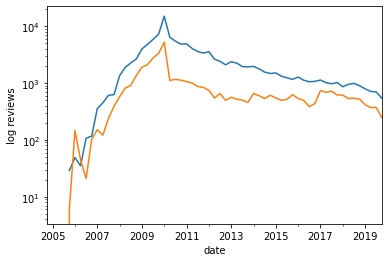

C:\Users\diogo\anaconda3\envs\econ21340-env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


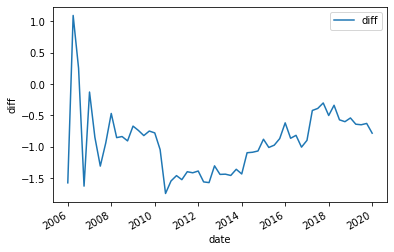

In [17]:
# Plot log number of reviews in each quarter for both groups as well as outcome in diff
jan_control_plot.plot()
plt.yscale("log") 
jan_treatment_plot.plot()
plt.yscale("log") 

plt.xlabel('date')
plt.ylabel('log reviews')
plt.show()

control = df_review[df_review['user_id'].isin(jan_control_users)]
treated = df_review[df_review['user_id'].isin(jan_treatment_users)]

control_q = control.groupby(pd.Grouper(key = 'date', freq="Q"))['review_id'].size()
treated_q = treated.groupby(pd.Grouper(key = 'date', freq="Q"))['review_id'].size()

total = control_q.reset_index().merge(treated_q.reset_index(), how='outer', on='date').replace(np.nan, 0)
total['diff'] = np.log(total['review_id_y']) - np.log(total['review_id_x'])

total.plot(x='date', y='diff')
plt.xlabel('date')
plt.ylabel('diff')
plt.show()

# Using activity per user and time

We are now interested in conducting some inference on our results. However we remember that the level of randomization is the `user` not the `review`. Hence we now decide to construct observation at the `(user,year)` level. We decide to use years instead of months because the probability at the month level is too low.

 1. Construct a DataFrame with all `(user,year)` pairs and a column called `post` which is equal to 1 if the user posted in that year and 0 if he didn't. To construct such dataframe I used the `pd.MultiIndex.from_product` function, but one could use a `merge` instead.
 2. Use this newly created DataFrame to plot the level for each group and each, and to plot the difference between the two.
 
Here are the plots I constructed:

In [18]:
list_years = list(df_review.date.dt.year.unique())
list_users = list(jan_df.user_id.unique())

pairs = pd.DataFrame(index = pd.MultiIndex.from_product([list_users, list_years])).reset_index()
pairs = pairs.rename(columns={'level_0': 'user_id', 'level_1': 'year'})

In [19]:
df_review['year'] = df_review.date.dt.year
pairs_posted = pairs.merge(df_review[['user_id', 'year']], how = 'inner')
pairs_posted = pairs_posted.drop_duplicates()

In [20]:
pairs_posted.reset_index(drop=True, inplace=True)
pairs_posted['post'] = int(1)
pairs = pairs_posted.merge(pairs[['user_id', 'year']], how = 'outer')
pairs['post'] = pairs['post'].fillna(int(0))

In [21]:
pairs['treat'] = pairs['user_id'].isin(jan_treatment_users)

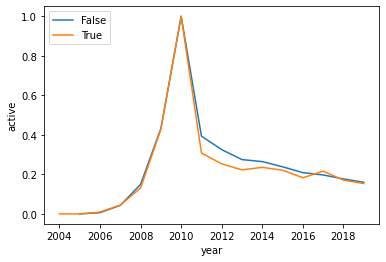

In [22]:
post_t = pairs[pairs['treat'] == True]
post_t = post_t[post_t['post'] == 1]
plot_t = post_t.groupby('year')['post'].count()/len(jan_treatment_users)

post_c = pairs[pairs['treat'] == False]
post_c = post_c[post_c['post'] == 1]
plot_c = post_c.groupby('year')['post'].count()/len(jan_control_users)

plot_c.plot(label='False')
plot_t.plot(label='True')
plt.legend(loc="upper left")
plt.xlabel('year')
plt.ylabel('active')
plt.show()

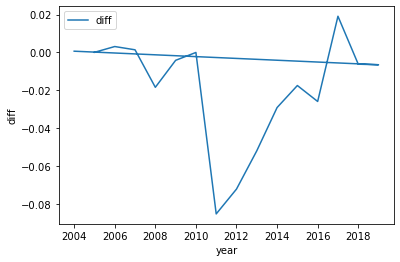

In [23]:
total_y = plot_c.reset_index().merge(plot_t.reset_index(), how='outer', on='year').replace(np.nan, 0)
total_y['diff'] = total_y['post_y'] - total_y['post_x']

total_y.plot(x='year', y='diff')
plt.ylabel('diff')
plt.show()

# Line connecting beginning and end point as well

# Construct confidence inference

In this final question our goal is to add some inference to our plot. We are going to simply use the asymptotic variance implied by the OLS formula. Do the following:

 1. create a function that will take a dataframe containing the columns `post` and `treat` and returns the OLS estimate of `post` on `treat` together with the estimate of the variance of that estimate (Remember that in this simple case $\hat{\beta} = cov(y,x)/var(x)$ and that teh variance is $\sigma^2_\epsilon/(n \cdot var(x))$. Return the results as a new dataframe with one row and 2 columns.
 2. apply your function to your data from question 4 within eave `year` (you can do that using `pd.Grouper(freq='Y',key='date')` within a `groupby` and use the `apply` method.
 3. use your grouped results to plot the mean together with their 95% asymptotic conf interval
 4. comment on the results, in particular on date before the start of the experiment.
 
I report the plot I got:

In [24]:
def OLSEst(df):
    cov = df.post.cov(df.treat)
    var = np.var(df.treat) 
    beta = cov / var
    v_est = np.var(df.post) / (df.shape[0] * var)
    params = pd.DataFrame({"beta": beta, "v_est": v_est}, index=[0])
    return params


In [25]:
params = OLSEst(pairs)
params

,beta,v_est
0,-0.018286,0.000011


In [26]:
params['v_est'][0]

1.0900477181620725e-05

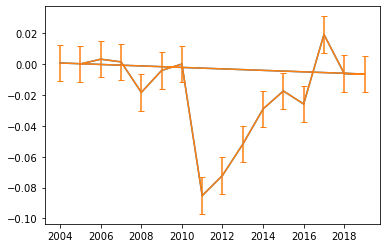

In [27]:
plt.rcParams.update({'errorbar.capsize':3})
error = params['beta'][0]+np.sqrt(params['v_est'][0])*1.96
plt.plot(total_y.year, total_y['diff'])
plt.errorbar(total_y.year, total_y['diff'], yerr=error)
plt.show()

Response: It appears that after the user interface was introduced, there was a significant drop in rating activity among the treated group compared to the control (given the lack of overlap in error bars between 2010 and years until 2014). Before January 2010, however, the treatment group rating activity did not differ significantly from the control. It wasn't until about four years later did the rating activity among the treated group normalize and start to differ little from the control group again. This may be indicative of users that continued to use Yelp despite their apparent dislike for the new user interface, eventually getting used to the interface and seeing it as normal as the control group sees their interface. The fact that these levels end up not being statisitically different from the control almost a decade later could also have to do with the fact that people in the treatment group were selected out of a group of users that post reviews *at all* and are then more likely to have regular review activity and stick to the site.